In [1]:
import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im_show1 = Image.open('dataset/rsna/CXR/0a0f91dc-6015-4342-b809-d19610854a21.png').convert('RGB')
label_show1 = Image.open('dataset/rsna/Mask/G(0a0f91dc-6015-4342-b809-d19610854a21).png').convert('RGB')
im_show2 = Image.open('dataset/rsna/CXR/0a2c130c-c536-4651-836d-95d07e9a89cf.png').convert('RGB')
label_show2 = Image.open('dataset/rsna/Mask/G(0a2c130c-c536-4651-836d-95d07e9a89cf).png').convert('RGB')

(1024, 1024)
(1024, 1024)


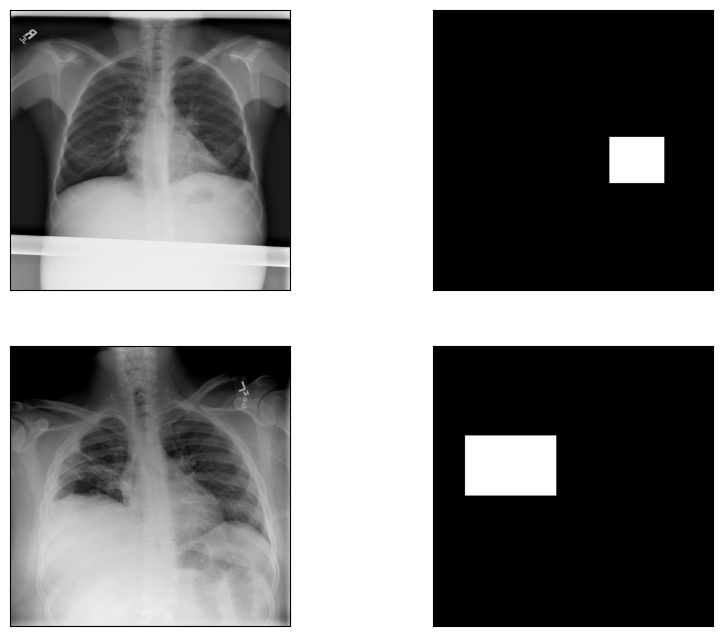

In [3]:
_, figs = plt.subplots(2, 2, figsize=(10, 8))
figs[0][0].imshow(im_show1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].imshow(label_show1)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
figs[1][0].imshow(im_show2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].imshow(label_show2)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(im_show1.size)
print(im_show2.size)

In [4]:
from torchvision import transforms
classes = ['background','1']

# RGB color for each class
colormap = [[0,0,0],[255,255,255]]

In [5]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

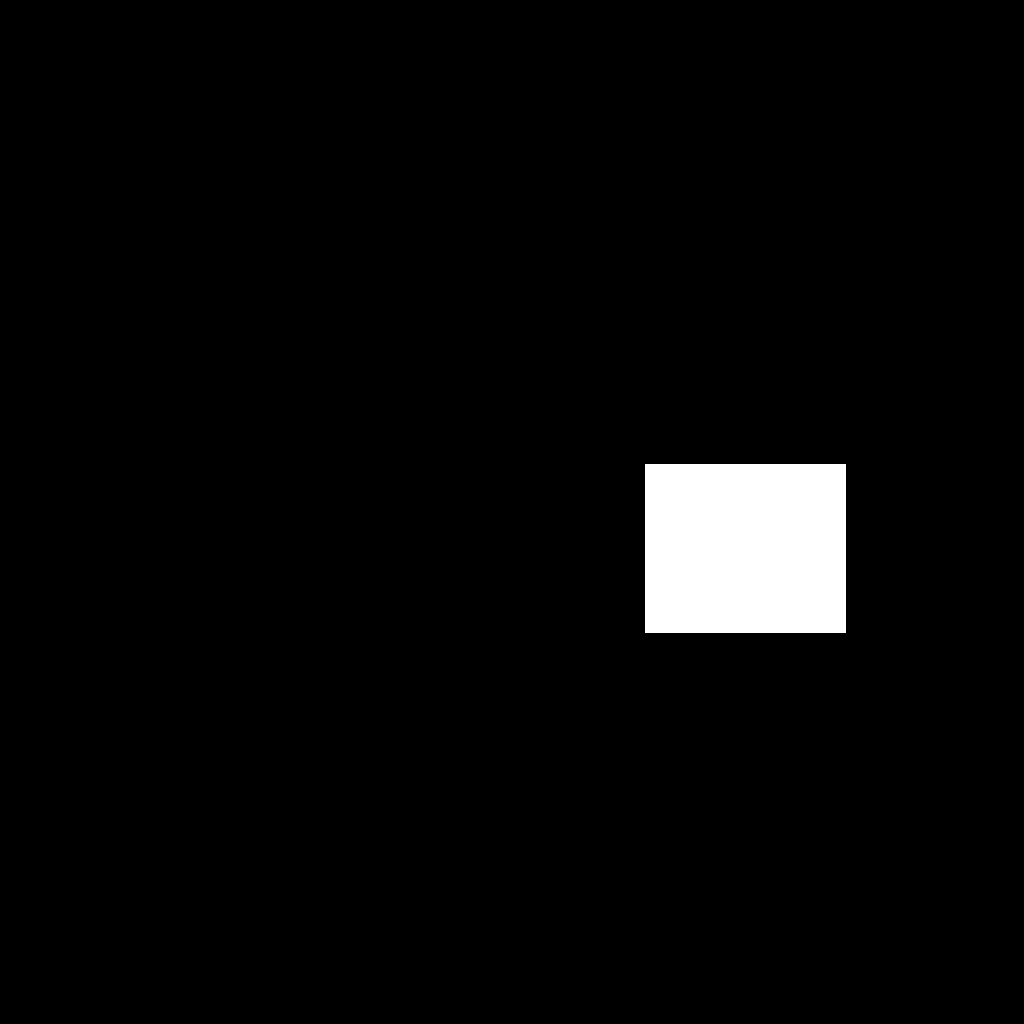

In [6]:
label_im = Image.open('dataset/rsna/Mask/G(0a0f91dc-6015-4342-b809-d19610854a21).png').convert('RGB')
label_im

In [7]:
label = image2label(label_im)
label.shape

(1024, 1024)

In [8]:
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
class my_dataset(Dataset):
    def __init__(self,path,transform):
        self.path = path
        self.data_path = f'{path}/CXR'
        self.mask_path = f'{path}/Mask'
        self.data = os.listdir(self.data_path)
        self.mask = os.listdir(self.mask_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = Image.open(self.data_path+'/'+self.data[index]).convert('RGB')
        mask = Image.open(self.mask_path+'/'+self.mask[index]).convert('RGB')
        
        img = self.transform(img)
        mask = transforms.Resize((512,512))(mask)
        mask = image2label(mask)
        label = torch.from_numpy(mask)
        
        return img,label

In [10]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # 其他必要的预处理步骤
])

In [11]:
path='./dataset/rsna'
dataset=my_dataset(path,transform)

In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [13]:
import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms
# 加载预训练的FCN模型
model = models.segmentation.fcn_resnet101(pretrained=True)

# 修改最后的卷积层
model.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

# 将Sigmoid激活函数添加到输出层
model.add_module('sigmoid', torch.nn.Sigmoid())

c:\Users\armstrong\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\armstrong\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model.cuda()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)
criterion.cuda()

CrossEntropyLoss()

In [16]:
for e in range(10):
    train_loss = 0
    
    model.train()
    for im,labels in train_dataloader:
        im = im.cuda()
        labels = labels.cuda()
        out= model(im)
        out = torch.softmax(out['out'], dim=1)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(e, train_loss/len(train_dataloader)))

    model.eval()
    eval_loss = 0
    for im,labels in val_dataloader:
        im = im.cuda()
        labels = labels.cuda()
        out= model(im)
        out = torch.softmax(out['out'], dim=1)
        loss = criterion(out, labels)
        eval_loss += loss
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(e, eval_loss/len(val_dataloader)))

Epoch: 0 	Training Loss: 0.406706


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 11.99 GiB total capacity; 25.53 GiB already allocated; 0 bytes free; 26.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF